# Automated Co-occurrence Pipeline Analysis

In [29]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from helper_functions import *
from pandas.tseries.offsets import DateOffset
import warnings
from sklearn.preprocessing import MultiLabelBinarizer
from mlxtend.frequent_patterns import apriori, association_rules
import seaborn as sns
warnings.filterwarnings("ignore")

# Modify if the raw data structure changed
trash_columns = ['id_x_x','sikka_sub_task_operation_x_x','office_x_x','guarantor_x','patient','description','visible_to_patient','primary_insurance_estimate','secondary_insurance_estimate','plan_sr_no','insurance_payment','approved','from_pms_x_x','id_y_x','from_pms_y_x','sikka_sub_task_y_x','sikka_sub_task_operation_y_x','uuid','guarantor_y','office_y_x','fullname','first_name','last_name','address','phone','zip_code','practice','primary_insurance_company_id','profile_picture','date_joined','zip_code_flag','address_comp','final_zip_code','id_x_y','from_pms_x_y','office_x_y','treatment','id_y_y','from_pms_y_y','sikka_sub_task_y_y','sikka_sub_task_operation_y_y','office_y_y','procedure_code_x','procedure_code_description','patient_friendly_description','treatment_id','price','fetched_zip_code_flag','zip_code_verified','fetched_zip_code', 'entry_date', 'tooth_from']
meta_cols = ['provider_x', 'amount', 'treatment_plan_status', 'patient_id', 'city','state_y', 'sikka_provider_id', 'LATITUDE', 'LONGITUDE', 'procedure_age', 'visit_period']
base_cols = ['patient_id', 'procedure_age']

In [54]:
# To be filled (Need to update)
# Path to helper_function.py
helper_function_path = r"C:\Frank\UoT 2024-2025\MIE8888 Project\SmilePass-2\Co-occurence_Analysis\helper_functions.py"
# Path to raw full data
full_dataset_path = r"C:\Frank\UoT 2024-2025\MIE8888 Project\full_dataset_2.11.csv"
# Path to the procedure code mapping excel file
Procedure_code_description_path = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M24\Procedure_Description_Mapping.xlsx"

# Path with the name 21_treatements_backup_joined_patients; 21_TreatmentProcedure_backup(in) and 21_ProcedureCode_backup(in)
Data_Patient = r"C:\Frank\UoT 2024-2025\MIE8888 Project\Data\Complete Data\21_treatements_backup_joined_patients.csv"
Data_TreatmentProcedure = r"C:\Frank\UoT 2024-2025\MIE8888 Project\Data\Complete Data\21_TreatmentProcedure_backup(in).csv"
Data_ProcedureCode = r"C:\Frank\UoT 2024-2025\MIE8888 Project\Data\Complete Data\21_ProcedureCode_backup(in).csv"

# Time Window (in month) and step month (how detailed and overlapping of the analysis)
window_months = 6
step_months = 3
Interested_in_sequential = True

- V3 (Inconsistent, Long History) dominates across nearly all age groups, suggests many patients have long timelines but irregular visit patterns.
- V1 (Consistent, Long History) is the second largest group and it has strongest presence in 0–18 and 31–60 which reflects patients with reliable visit patterns and long history.
- V2, V4 may not be relevant data as they don't add value.
- Consider to combine v1 and v3 and use it throughout this study

In [15]:
# Data Segmentation
full_dataset = full_dataset_path
df = pd.read_csv(full_dataset, encoding="Windows-1252")

# Delete trash columns and clean the data
df = drop_high_nan_columns(df) # Drop columns with more than 50% missing values
df = df.drop(columns = trash_columns) # Drop trash cols
df = merge_columns_with_priority(df,'health_category','procedure_code_category','treatment_category') # merge to get treatment_category with pattern from two category groups
df = df.dropna() # Drop the remaining NA
df, df_dict = object_processing(df) # Project columns dtype = object; For columns containing datetime, convert it to pd.datetime; For other object columns, encode them
df = days_cal_v2(df,'procedure_date','birth_date', 'procedure_age') # procedure_age
df = days_cal_v2(df,'last_visit','first_visit','visit_period') # visit_period
df = one_hot_encode_procedure_and_treatment(df) # # Perform one-hot encoding on the "procedure_code_y" and "treatment_category"

## Store the data loaclly and make a copy for next steps' use
# df.to_csv(r'C:\Frank\UoT 2024-2025\MIE8888 Project\M18\output.csv', index=False)
df_next = df.copy()

# Data Segmentation
patient_versions = df_next.groupby('patient_id').apply(classify_patient).reset_index()
patient_versions.columns = ['patient_id', 'version']
df_next = df_next.merge(patient_versions, on='patient_id')

# Data Segmentation
df_v1 = df_next[df_next['version'] == 'V1']
df_v2 = df_next[df_next['version'] == 'V2']
df_v3 = df_next[df_next['version'] == 'V3']
df_v4 = df_next[df_next['version'] == 'V4']
df_v1_v3 = df_next[df_next['version'].isin(['V1', 'V3'])]
df_v2_v4 = df_next[df_next['version'].isin(['V2', 'V4'])]

# Create patient id map for segmented data
v1_map = df_v1[['patient_id']]
v1v3_map = df_v1_v3[['patient_id']]
v2v4_map = df_v2_v4[['patient_id']]
df_next['version'].value_counts()

version
V3    180491
V1    103641
V2     34236
V4     14147
Name: count, dtype: int64

In [ ]:
# Create time window and encoding the data

# Load data
df_treat = pd.read_csv(Data_Patient)
df_connect = pd.read_csv(Data_TreatmentProcedure)
df_pro = pd.read_csv(Data_ProcedureCode)

# Clean and join treatment-procedure mapping
df_connect_clean = (
    df_connect
    .assign(procedure_code=lambda x: x['procedure_code'].str.extract(r'\((\d+)\)'))
    .dropna(subset=['procedure_code'])

    .assign(procedure_code=lambda x: x['procedure_code'].astype(int))
    .merge(df_pro, left_on='procedure_code', right_on='id', how='left')
    .dropna(subset=['treatment'])

    .assign(treatment_id=lambda x: x['treatment'].str.extract(r'^(\d+)'))
    .dropna(subset=['treatment_id'])
    .assign(treatment_id=lambda x: x['treatment_id'].astype(int))
)

# Join with patient treatment table
df_treat_joined = df_treat.merge(df_connect_clean, left_on='id_x', right_on='treatment_id', how='left')

# Preprocess and sort by date ===
df_treat_joined['procedure_date'] = pd.to_datetime(df_treat_joined['procedure_date'], errors='coerce')
df_treat_joined = df_treat_joined.dropna(subset=['procedure_date'])
df_treat_joined = df_treat_joined.sort_values(['patient_id', 'procedure_date']).reset_index(drop=True)

# Generate time windows per patient
print("Generating time window...")
df_input_total = generate_sliding_windows(df_treat_joined, window_months, step_months, Interested_in_sequential, date_col='procedure_date', code_col='procedure_code_y')
print("Time windows completed")
# Filter for V1 and V3 patients
df_input = df_input_total[df_input_total['patient_id'].isin(v1v3_map['patient_id'])].copy()

# Add patient names
df_patient = df_treat_joined[['patient_id', 'patient']].drop_duplicates()

if not Interested_in_sequential:
    df_input = df_input.merge(df_patient, on='patient_id', how='left')
    # Feature engineering: list length
    df_input['procedure_codes_len'] = df_input['procedure_codes'].apply(len)

    # Filter procedure codes
    df_input['procedure_codes'] = df_input['procedure_codes'].apply(filter_codes)
    df_input_rem = df_input[df_input['procedure_codes'].str.len() > 0].reset_index(drop=True)

    # One-hot encode the multi-label column
    mlb = MultiLabelBinarizer()
    encoded_df = pd.DataFrame(mlb.fit_transform(df_input_rem['procedure_codes']), columns=mlb.classes_)

    # Combine encoded data with metadata
    result = pd.concat([df_input_rem[['patient_id', 'window_start', 'window_end', 'procedure_codes', 'procedure_codes_len']], encoded_df], axis=1)
else:
    df_input = df_input.merge(df_patient, left_on='patient_id', right_on='patient_id', how='left')
    df_input = df_input[['patient_id', 'current_procedure_codes', 'next_procedure_codes']]
    
    # Apply the filtering function
    df_input['current_procedure_codes'] = df_input['current_procedure_codes'].apply(filter_codes)
    df_input['next_procedure_codes'] = df_input['next_procedure_codes'].apply(filter_codes)

    # Drop rows where procedure_codes become empty after filtering
    df_input_rem = df_input[df_input['current_procedure_codes'].str.len() > 0].reset_index(drop=True)
    df_input_rem = df_input_rem[df_input_rem['next_procedure_codes'].str.len() > 0].reset_index(drop=True)

    # Encode current and next procedure codes separately
    encoded_current = encode_procedures(df_input_rem, 'current_procedure_codes')
    encoded_next = encode_procedures(df_input_rem, 'next_procedure_codes')

    # Combine the current and next encoded DataFrames, but not flatten them
    # This ensures that we maintain separate columns for current and next treatments
    encoded_df = pd.concat([encoded_current, encoded_next], axis=1)

print(f'{window_months}-month time window with step months of {step_months} has been created and encoded successfully. The data now is ready for apriori algorithm')

Generating time window...
Time windows completed


KeyError: 'procedure_codes'

In [31]:
# Apply Apriori Algorithm

# Get frequent itemsets
frequent_itemsets = apriori(encoded_df, min_support=0.0025, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets_df = pd.DataFrame(frequent_itemsets)
frequent_itemsets_df.to_csv('frequent_itemsets_windowed_new.csv', index=False)

# Get association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.05, num_itemsets=len(frequent_itemsets))
rules = rules.sort_values(by='lift', ascending=False)
rules_df = pd.DataFrame(rules)
rules_df.to_csv('rules_windowed_new.csv', index=False)

<Axes: xlabel='support', ylabel='confidence'>

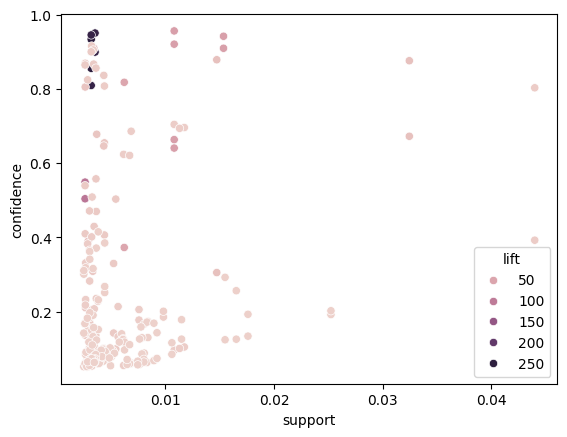

In [36]:
# Plot scatter x-axis support, y-axis confidence, color lift
sns.scatterplot(data=rules_df, x='support', y='confidence', hue='lift')

In [34]:
# New task of 1<lift<50

# Convert frozensets to string representations
rules_df['antecedents'] = rules_df['antecedents'].apply(lambda x: ', '.join(map(str, sorted(x))))
rules_df['consequents'] = rules_df['consequents'].apply(lambda x: ', '.join(map(str, sorted(x))))

rules_focus = rules_df[(rules_df['lift'] > 2) & (rules_df['lift'] < 50)].sort_values(by='lift', ascending=False)

# Create the pivot table for the heatmap
pivot = rules_focus.pivot(index='antecedents', columns='consequents', values='lift')
update_rule = rules_focus[['antecedents', 'consequents', 'lift']]

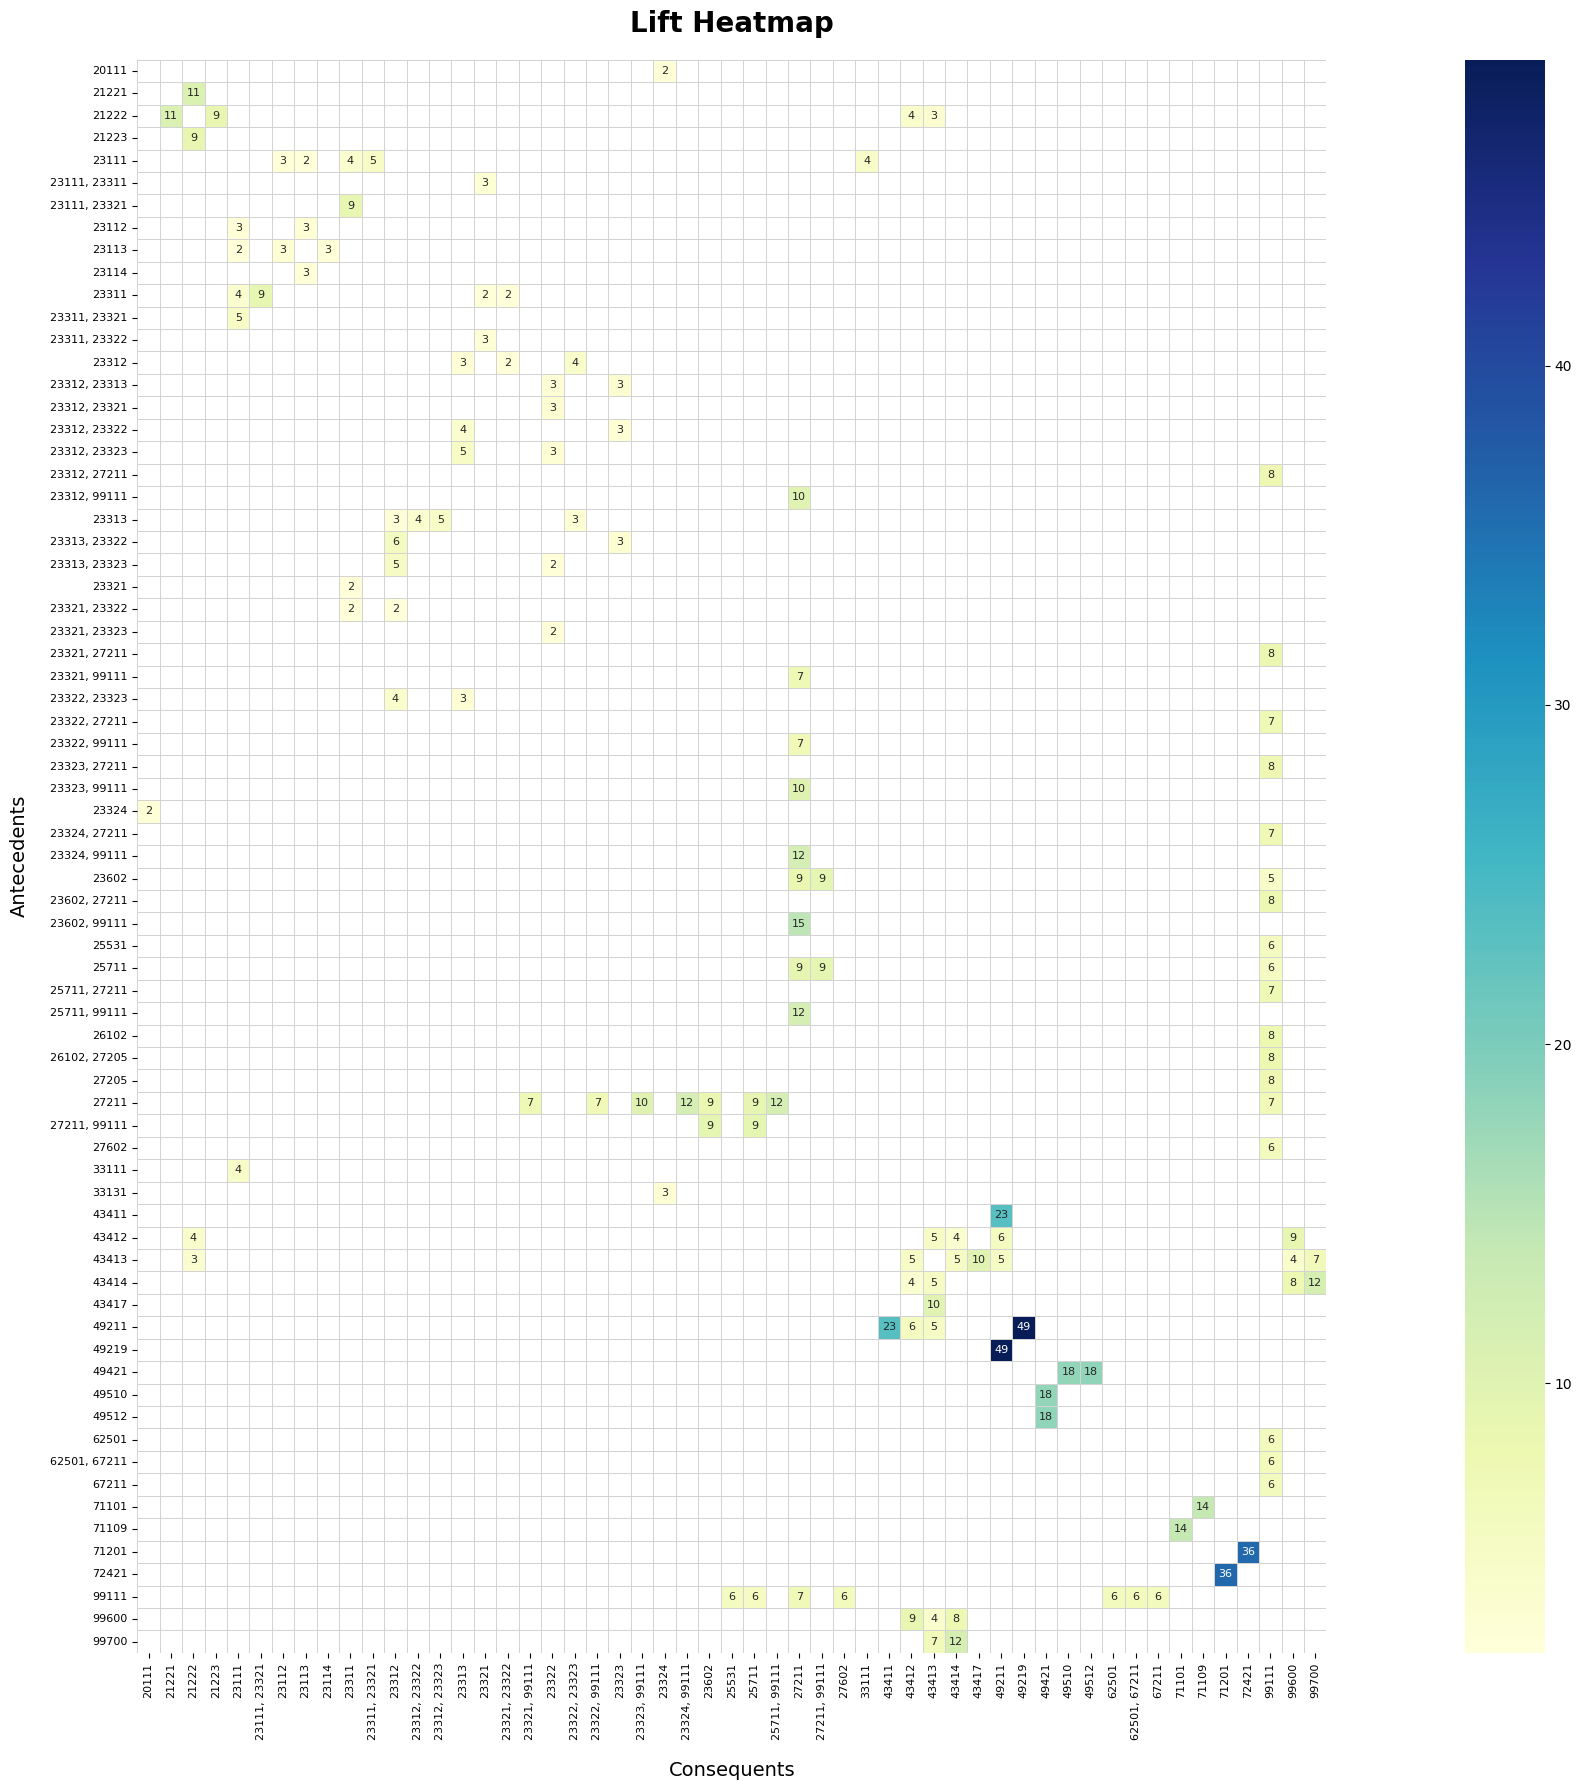

In [ ]:
# Output
plt.figure(figsize=(28, 18))  # Bigger figure for better readability

# Better color palette and formatting
sns.heatmap(
    pivot,
    annot=True,
    fmt='.0f',
    cmap="YlGnBu",
    cbar=True,
    linewidths=0.5,
    linecolor='lightgray',
    square=True,  # Makes cells square for uniformity
    annot_kws={"size": 8}  # Smaller annotation text
)

# Titles and labels
plt.title('Lift Heatmap', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Consequents', fontsize=14, labelpad=15)
plt.ylabel('Antecedents', fontsize=14, labelpad=15)

# Rotate tick labels for better visibility
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)

# Add tighter layout
plt.tight_layout()
plt.show()
